# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import datetime

# Acquire the data

Data is presented in two sets. One with whole data of 2015 and the first three months of 2016 and since this data is large another data set is presented containing subset of the original data

In [2]:
iowa_data = pd.read_csv("../dataset/Iowa_Liquor_Sales_reduced.csv")
iowa_data_sample = pd.read_csv("../dataset/Iowa_Liquor_sales_sample_10pct.csv")

/home/ali/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Explore the data

We can have a brief description of the dataset here.

In [3]:
iowa_data.head(2)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53


In [4]:
iowa_data.describe()

/home/ali/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Store Number,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),Bottles Sold,Volume Sold (Liters),Volume Sold (Gallons)
count,2.709552e+06,2.698639e+06,2.708773e+06,2.709552e+06,2.709552e+06,2.709552e+06,2.709552e+06,2.709552e+06,2.709552e+06
mean,3.589071e+03,5.726086e+01,1.043826e+06,2.563901e+02,4.601624e+04,9.242111e+02,9.838390e+00,8.921504e+00,2.357017e+00
std,9.491083e+02,2.732565e+01,5.003493e+04,1.408757e+02,5.311268e+04,5.464858e+02,2.349863e+01,2.824435e+01,7.461356e+00
min,2.106000e+03,1.000000e+00,1.011100e+06,1.000000e+01,1.460000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.604000e+03,NaN,NaN,1.150000e+02,2.682800e+04,7.500000e+02,2.000000e+00,1.500000e+00,4.000000e-01
50%,3.721000e+03,NaN,NaN,2.600000e+02,3.817600e+04,7.500000e+02,6.000000e+00,5.250000e+00,1.390000e+00
75%,4.382000e+03,NaN,NaN,3.800000e+02,6.460100e+04,1.000000e+03,1.200000e+01,1.050000e+01,2.770000e+00
max,9.023000e+03,9.900000e+01,1.701100e+06,9.780000e+02,9.992750e+05,2.250000e+05,3.960000e+03,3.960000e+03,1.046120e+03


In [5]:
for name in iowa_data.columns:
    print name
    print iowa_data[name].describe(), "\n"

Date
count        2709552
unique           284
top       12/01/2015
freq           15588
Name: Date, dtype: object 

Store Number
count    2.709552e+06
mean     3.589071e+03
std      9.491083e+02
min      2.106000e+03
25%      2.604000e+03
50%      3.721000e+03
75%      4.382000e+03
max      9.023000e+03
Name: Store Number, dtype: float64 

City
count        2709552
unique           386
top       DES MOINES
freq          237791
Name: City, dtype: object 

Zip Code
count     2709552
unique        771
top         50010
freq        67815
Name: Zip Code, dtype: object 

County Number
count    2.698639e+06
mean     5.726086e+01
std      2.732565e+01
min      1.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      9.900000e+01
Name: County Number, dtype: float64 

County
count     2698639
unique         99
top          Polk
freq       491953
Name: County, dtype: object 

Category
count    2.708773e+06
mean     1.043826e+06
std      5.003493e+04
min      1.0111

Data set apperas to be well formatted and well maintained. there are little absent data which most of it are easily forgivable or replacable. what we can find out from looking at data description is as follow:
1. There seems to be 270955 record of data
2. there seems to be some data missing from "County Number", "Category", "County" and "Category Name"
3. Date column is extracted as string type which makes it hard to wirk on it

First we need to address the missing data. We either have to remove records with lost data or fill them with exploration.
We can fill County and County number of some stores simply by looking at records which those columns are present.

In [6]:
stores = iowa_data[(iowa_data['County Number'].isnull())]['Store Number'].value_counts().reset_index()
for s in stores['index']:
    d = iowa_data[(iowa_data['Store Number'] == s) & (~iowa_data['County Number'].isnull())]
    if len(d) > 0:
        iowa_data.loc[(iowa_data['Store Number'] == s), ['County Number', 'County']] = d.iat[0,4], d.iat[0,5]

Now we have decreased field without "County" and "County Name" we can go further use zip codes to determine more counties but since zip codes may be used by more than one county its not a good Idea

We can do the same with 'Category' and 'Category Name' but as we discover later we can't fill the missing data this way. so I decide to Change unfilled 'Category' to 0 and 'Category Name' to 'Unknown' so I can use them later as a single category.

In [7]:
iowa_data.loc[(iowa_data['Category'].isnull()), ['Category', 'Category Name']] = 0, 'Unknown'

Next I change 'Date' type from 'String' to "dateTime'

In [8]:
iowa_data['Date'] = pd.to_datetime(iowa_data['Date'], format='%m/%d/%Y')

Also we can see 'Sale (Dollars)', 'State Bottle Retail' and 'State Bottle Cost' are strings so we have to convert them to float inorder to be usefull

In [9]:
iowa_data['Sale (Dollars)'] = iowa_data['Sale (Dollars)'].apply(lambda x: float(x.replace("$", "")))
iowa_data['State Bottle Retail'] = iowa_data['State Bottle Retail'].apply(lambda x: float(x.replace("$", "")))
iowa_data['State Bottle Cost'] = iowa_data['State Bottle Cost'].apply(lambda x: float(x.replace("$", "")))

In [10]:
record_2015 = iowa_data[(iowa_data['Date'] > '01/1/2015') & (iowa_data['Date'] <= '01/1/2016')]

In [11]:
store_records = pd.pivot_table(record_2015,
        index = 'Store Number',
        values = 'Sale (Dollars)',
        aggfunc= np.sum
        ).reset_index()

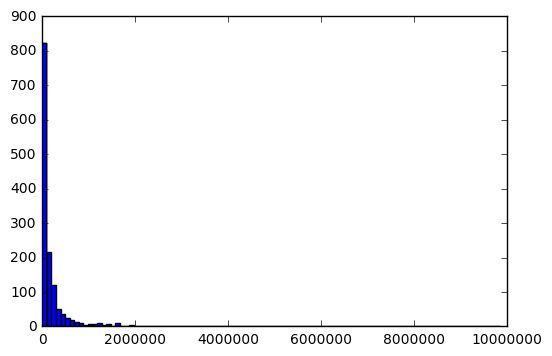

In [12]:
plt.ticklabel_format(style='plain')
plt.hist(store_records['Sale (Dollars)'], bins=100)
plt.show()

In [13]:
daily_sales = pd.pivot_table(record_2015,
        index = 'Date',
        values = 'Sale (Dollars)',
        aggfunc= np.sum
        ).reset_index()
daily_sales['Day'] = daily_sales['Date'].apply(lambda x: datetime.datetime.date(x).weekday())
daily_sales = daily_sales.pivot_table(index='Day', values='Sale (Dollars)', aggfunc=np.sum).reset_index()

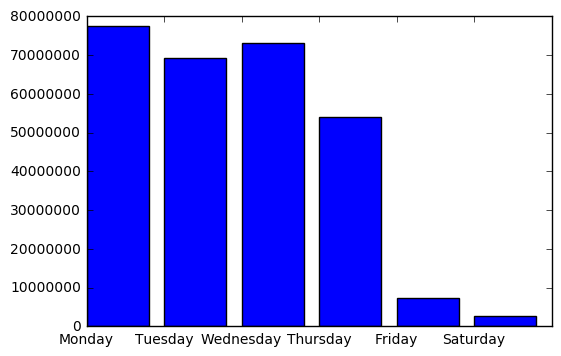

In [14]:
LABELS = ["Monday", "Tuesday", "Wednesday", 'Thursday', "Friday", 'Saturday', 'Sunday']
plt.ticklabel_format(style='plain', useLocale=True)
plt.bar(daily_sales['Day'], daily_sales['Sale (Dollars)'])
plt.xticks(daily_sales['Day'], LABELS)
plt.show()

In [15]:
daily_sales = pd.pivot_table(record_2015,
        index = 'Date',
        values = 'Sale (Dollars)',
        aggfunc= np.sum
        ).reset_index()
daily_sales['Month'] = daily_sales['Date'].apply(lambda x: datetime.datetime.date(x).month)
daily_sales = daily_sales.pivot_table(index='Month', values='Sale (Dollars)', aggfunc=np.sum).reset_index()

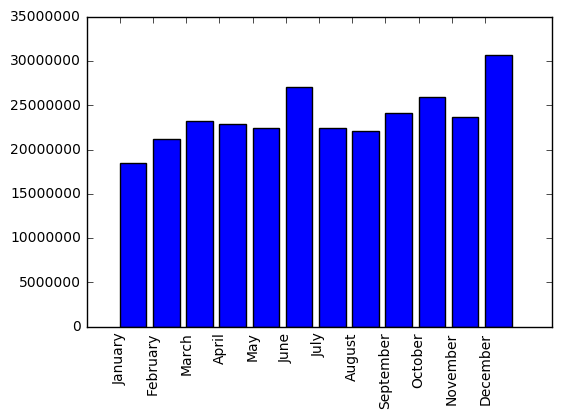

In [16]:
LABELS = [datetime.date(2016, i, 1).strftime('%B') for i in range(1,13)]
plt.ticklabel_format(style='plain')
plt.bar(daily_sales['Month'], daily_sales['Sale (Dollars)'])
plt.xticks(daily_sales['Month'], LABELS, rotation='vertical')
plt.show()

In [17]:
county_sales = pd.pivot_table(record_2015,
        index = 'County',
        values = 'Sale (Dollars)',
        aggfunc= np.sum
        ).reset_index()

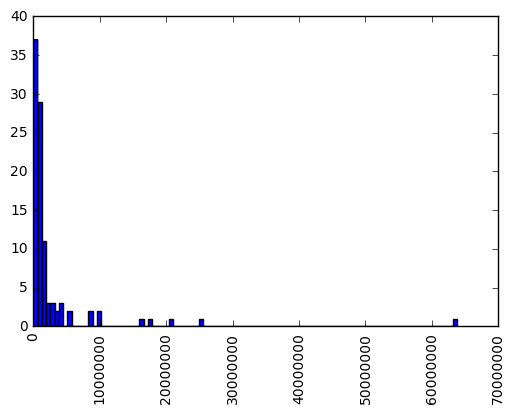

In [18]:
plt.ticklabel_format(style='plain')
plt.hist(county_sales['Sale (Dollars)'], bins=100)
plt.xticks(rotation='vertical')
plt.show()

# Scenario #1

##### Calculate the yearly liquor sales for each store using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable

In [19]:
record_2015 = iowa_data[(iowa_data['Date'] > '01/1/2015') & (iowa_data['Date'] <= '01/1/2016')]
record_jan_feb_march_2015 = iowa_data[(iowa_data['Date'] > '2015-1-1') & (iowa_data['Date'] <= '2016-4-1')]

In [20]:
store_sales_2015 = pd.pivot_table(record_2015,
        index = 'Store Number',
        values = ["Sale (Dollars)"],
        aggfunc = np.sum
       ).reset_index()
store_sales_2015.head()

,Store Number,Sale (Dollars)
0,2106,1434369.85
1,2113,85763.42
2,2130,1108184.99
3,2152,72080.36
4,2178,277987.96


##### Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of each store. You must use the sales from Jan to March per store as one of your variables.


Inorder to calculate a good prediction we are going to need more data. We are going to need number of stores in each county as an indicator of cmpetition and total sales of the first three months which shows performance of store

We can calculate number of stores in each county as follw:

In [21]:
stores_in_counties = record_2015.groupby('County Number')['Store Number'].nunique().reset_index()
stores_in_counties.head()

,County Number,Store Number
0,1.0,8
1,2.0,1
2,3.0,6
3,4.0,6
4,5.0,3


Inorder to crossrefrence we are going to need a data set indicating each store located in which county.

In [22]:
county_of_store = pd.pivot_table(
        record_2015, index='Store Number', 
        values='County Number', 
        aggfunc=np.mean
        )
county_of_store.head()

Store Number
2106     7.0
2113    94.0
2130     7.0
2152    17.0
2178     3.0
Name: County Number, dtype: float64

Now we build our dataset

In [23]:
store_sales = pd.pivot_table(record_2015,
    index = 'Store Number',
    values = ["Sale (Dollars)"],
    aggfunc=np.sum
    ).reset_index()
store_sales.head()

,Store Number,Sale (Dollars)
0,2106,1434369.85
1,2113,85763.42
2,2130,1108184.99
3,2152,72080.36
4,2178,277987.96


Now we calculate first three months sale of each store

In [24]:
three_months = pd.pivot_table(record_2015[(record_2015['Date'] >= '01/1/2015') & (record_2015['Date'] < '04/1/2015')],
    index = 'Store Number',
    values = ["Sale (Dollars)"],
    aggfunc=np.sum
    ).reset_index()
three_months.head()

,Store Number,Sale (Dollars)
0,2106,337166.53
1,2113,22351.86
2,2130,277764.46
3,2152,16805.11
4,2178,54411.42


We add three months sale to our dataset

In [25]:
store_sales = pd.merge(store_sales, three_months, on='Store Number', how='left')
store_sales.head()

,Store Number,Sale (Dollars)_x,Sale (Dollars)_y
0,2106,1434369.85,337166.53
1,2113,85763.42,22351.86
2,2130,1108184.99,277764.46
3,2152,72080.36,16805.11
4,2178,277987.96,54411.42


We add county number and number of stores in county to our dataset

In [26]:
store_sales = pd.concat([store_sales, stores_in_counties], axis=1, ignore_index=True)
store_sales.head()

,0,1,2,3,4
0,2106,1434369.85,337166.53,1.0,8.0
1,2113,85763.42,22351.86,2.0,1.0
2,2130,1108184.99,277764.46,3.0,6.0
3,2152,72080.36,16805.11,4.0,6.0
4,2178,277987.96,54411.42,5.0,3.0


Now rename the title to be more readable

In [27]:
store_sales.columns = ["Store Number", "Total Sale", "Three Month Sale", "County Number", "Stores in County"]
store_sales.head()

,Store Number,Total Sale,Three Month Sale,County Number,Stores in County
0,2106,1434369.85,337166.53,1.0,8.0
1,2113,85763.42,22351.86,2.0,1.0
2,2130,1108184.99,277764.46,3.0,6.0
3,2152,72080.36,16805.11,4.0,6.0
4,2178,277987.96,54411.42,5.0,3.0


Now we drop those stores which doesnt have three months sale

In [28]:
store_sales.dropna(subset=['Three Month Sale'], inplace=True)
store_sales.head()

,Store Number,Total Sale,Three Month Sale,County Number,Stores in County
0,2106,1434369.85,337166.53,1.0,8.0
1,2113,85763.42,22351.86,2.0,1.0
2,2130,1108184.99,277764.46,3.0,6.0
3,2152,72080.36,16805.11,4.0,6.0
4,2178,277987.96,54411.42,5.0,3.0


I could drop store whithouc 'Stores in County' but for now I decided to assign 1 to each and use them in my prediction

In [29]:
store_sales.loc[(store_sales['Stores in County'].isnull()), 'Stores in County'] = 1
store_sales.head()

,Store Number,Total Sale,Three Month Sale,County Number,Stores in County
0,2106,1434369.85,337166.53,1.0,8.0
1,2113,85763.42,22351.86,2.0,1.0
2,2130,1108184.99,277764.46,3.0,6.0
3,2152,72080.36,16805.11,4.0,6.0
4,2178,277987.96,54411.42,5.0,3.0


We can put all the above process inside a function to be usefull again

In [30]:
def generate_df(df, start_date, end_date, start_perion, end_perion):
    timed_record = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]
    stores_in_counties = timed_record.groupby('County Number')['Store Number'].nunique().reset_index()
    county_of_store = pd.pivot_table(timed_record, 
        index='Store Number', 
        values='County Number', 
        aggfunc=np.mean
        )
    store_sales = pd.pivot_table(timed_record,
        index = 'Store Number',
        values = ["Sale (Dollars)"],
        aggfunc=np.sum
        ).reset_index()
    months_record = pd.pivot_table(
        timed_record[(timed_record['Date'] >= start_perion) & 
                     (timed_record['Date'] < end_perion)],
        index = 'Store Number',
        values = ["Sale (Dollars)"],
        aggfunc=np.sum
        ).reset_index()
    store_sales = pd.merge(store_sales, months_record, on='Store Number', how='left')
    store_sales = pd.concat([store_sales, stores_in_counties], axis=1, ignore_index=True)
    store_sales.columns = ["Store Number", "Total Sale", "Three Month Sale", "County Number", "Stores in County"]
    store_sales.dropna(subset=['Three Month Sale'], inplace=True)
    store_sales.loc[(store_sales['Stores in County'].isnull()), 'Stores in County'] = 1
    return store_sales

In [31]:
variables = ['Three Month Sale', 'Stores in County']
st = generate_df(iowa_data, '01/1/2015', '01/1/2016', '01/1/2015', '04/1/2015')
X = st[variables]
y = st['Total Sale']
rlmcv = linear_model.RidgeCV(normalize=True)
model = rlmcv.fit(X, y)
predictions = model.predict(X)
print "r^2:"+str(model.score(X, y))+"\t alpha:"+str(rlmcv.alpha_)

r^2:0.972840943231	 alpha:0.1


r^2 calculated from our model shows a high number which means over fitting, But Since we are using RidgeCV I think we are OK!!!

In [32]:
st_2015=pd.concat([st, pd.DataFrame(predictions)], axis=1, ignore_index=True)
st_2015.head()

,0,1,2,3,4,5
0,2106.0,1434369.85,337166.53,1.0,8.0,1.333984e+06
1,2113.0,85763.42,22351.86,2.0,1.0,1.127532e+05
2,2130.0,1108184.99,277764.46,3.0,6.0,1.102769e+06
3,2152.0,72080.36,16805.11,4.0,6.0,9.713652e+04
4,2178.0,277987.96,54411.42,5.0,3.0,2.386011e+05


In [33]:
print "2015 prediction: ", np.sum(st_2015[5])
print "2015 total sale: ", np.sum(st_2015[1])
print "Percentage difference in sale: %", (np.sum(st_2015[5]) - np.sum(st_2015[1]))/np.sum(st_2015[1])*100

2015 prediction:  278340275.3
2015 total sale:  278340275.3
Percentage difference in sale: % 8.56572333431e-14


##### Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016

We can use the generated model to predict sales of 2016

In [34]:
st = generate_df(iowa_data, '01/1/2016', '01/1/2017', '01/1/2016', '04/1/2016')
X = st[variables]
y = st['Total Sale']
# we are going to use 2015 model in 2016
# rlmcv = linear_model.RidgeCV(normalize=True)
# model = rlmcv.fit(X, y)
predictions = model.predict(X)
print "r^2:"+str(model.score(X, y))+"\t alpha:"+str(rlmcv.alpha_)

r^2:-9.065869367	 alpha:0.1


In [35]:
st_2016=pd.concat([st, pd.DataFrame(predictions)], axis=1, ignore_index=True)
st_2016.head()

,0,1,2,3,4,5
0,2106,337804.05,337804.05,1.0,7.0,1.335289e+06
1,2113,21736.63,21736.63,2.0,1.0,1.103823e+05
2,2130,306942.27,306942.27,3.0,6.0,1.215208e+06
3,2152,13752.24,13752.24,4.0,6.0,8.537199e+04
4,2178,58939.90,58939.90,5.0,2.0,2.549004e+05


In [36]:
print "2016 prediction: ", np.sum(st_2016[5])
print "2016 Three Months sale: ", np.sum(st_2016[2])

2016 prediction:  289027745.641
2016 Three Months sale:  65526344.18


##### Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature

We can predict total sale in 2016 would be as follow:

In [37]:
# predicted sale in 2016
print "2016 prediction: ", np.sum(st_2016[5])
print "2015 total sale: ", np.sum(st_2015[1])
print "predicted increase in sale: ", np.sum(st_2016[5]) - np.sum(st_2015[1])
print "Percentage increase in sale: %", (np.sum(st_2016[5]) - np.sum(st_2015[1]))/np.sum(st_2015[1])*100

2016 prediction:  289027745.641
2015 total sale:  278340275.3
predicted increase in sale:  10687470.3407
Percentage increase in sale: % 3.83971393618


Our findings show we would have 3.9% increase in sales in 2016

##### Use cross-validation to check how your model predicts to held out data compared to the model metrics on the full dataset.

In [38]:
def data_cleaner(df):
    stores = df[(df['County Number'].isnull())]['Store Number'].value_counts().reset_index()
    for s in stores['index']:
        d = df[(df['Store Number'] == s) & (~df['County Number'].isnull())]
        if len(d) > 0:
            df.loc[(df['Store Number'] == s), ['County Number', 'County']] = d.iat[0,4], d.iat[0,5]

    df.loc[(df['Category'].isnull()), ['Category', 'Category Name']] = 0, 'Unknown'
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df['Sale (Dollars)'] = df['Sale (Dollars)'].apply(lambda x: float(x.replace("$", "")))
    df['State Bottle Retail'] = df['State Bottle Retail'].apply(lambda x: float(x.replace("$", "")))
    df['State Bottle Cost'] = df['State Bottle Cost'].apply(lambda x: float(x.replace("$", "")))
    return df

In [39]:
st = generate_df(data_cleaner(iowa_data_sample), '01/1/2015', '01/1/2016', '01/1/2015', '04/1/2015')
X = st[variables]
y = st['Total Sale']
# we are going to use 2015 model in 2016
# rlmcv = linear_model.RidgeCV(normalize=True)
# model = rlmcv.fit(X, y)
predictions = model.predict(X)
print "r^2:"+str(model.score(X, y))+"\t alpha:"+str(rlmcv.alpha_)

r^2:0.706189154561	 alpha:0.1


In [40]:
sample_2015=pd.concat([st, pd.DataFrame(predictions)], axis=1, ignore_index=True)
sample_2015.head()

,0,1,2,3,4,5
0,2106.0,146326.22,39287.29,1.0,8.0,186077.126050
1,2113.0,9310.22,2833.25,2.0,1.0,37536.291589
2,2130.0,111871.43,24272.57,3.0,6.0,125913.111754
3,2152.0,7721.08,2003.46,4.0,6.0,40096.915596
4,2178.0,24324.18,5856.41,5.0,3.0,51489.655114


Now lets do modelling on sample data and apply it to complete data

In [42]:
iowa_data = pd.read_csv("../dataset/Iowa_Liquor_Sales_reduced.csv")
iowa_data_sample = pd.read_csv("../dataset/Iowa_Liquor_sales_sample_10pct.csv")

In [43]:
st = generate_df(data_cleaner(iowa_data_sample), '01/1/2015', '01/1/2016', '01/1/2015', '04/1/2015')
X = st[variables]
y = st['Total Sale']
rlmcv = linear_model.RidgeCV(normalize=True)
model = rlmcv.fit(X, y)
predictions = model.predict(X)
print "r^2:"+str(model.score(X, y))+"\t alpha:"+str(rlmcv.alpha_)

r^2:0.955235640191	 alpha:0.1


In [44]:
sample_2015=pd.concat([st, pd.DataFrame(predictions)], axis=1, ignore_index=True)
sample_2015.head()

,0,1,2,3,4,5
0,2106.0,146326.22,39287.29,1.0,8.0,162205.890857
1,2113.0,9310.22,2833.25,2.0,1.0,13716.638108
2,2130.0,111871.43,24272.57,3.0,6.0,101108.583466
3,2152.0,7721.08,2003.46,4.0,6.0,10702.146980
4,2178.0,24324.18,5856.41,5.0,3.0,26131.523637


In [45]:
st = generate_df(data_cleaner(iowa_data), '01/1/2015', '01/1/2016', '01/1/2015', '04/1/2015')
X = st[variables]
y = st['Total Sale']
# rlmcv = linear_model.RidgeCV(normalize=True)
# model = rlmcv.fit(X, y)
predictions = model.predict(X)
print "r^2:"+str(model.score(X, y))+"\t alpha:"+str(rlmcv.alpha_)

r^2:0.978136388474	 alpha:0.1


In [46]:
st_2016=pd.concat([st, pd.DataFrame(predictions)], axis=1, ignore_index=True)
st_2016.head()

,0,1,2,3,4,5
0,2106.0,1434369.85,337166.53,1.0,8.0,1.371513e+06
1,2113.0,85763.42,22351.86,2.0,1.0,9.295680e+04
2,2130.0,1108184.99,277764.46,3.0,6.0,1.130216e+06
3,2152.0,72080.36,16805.11,4.0,6.0,7.079276e+04
4,2178.0,277987.96,54411.42,5.0,3.0,2.232515e+05


In [47]:
print "2015 sample prediction: ", np.sum(sample_2015[5])
print "2015 sample total sale: ", np.sum(sample_2015[1])
print "Percentage difference in sale: %", (np.sum(sample_2015[5]) - np.sum(sample_2015[1]))/np.sum(sample_2015[1])*100

print "2015 prediction: ", np.sum(st_2015[5])
print "2015 total sale: ", np.sum(st_2015[1])
print "Percentage difference in sale: %", (np.sum(st_2015[5]) - np.sum(st_2015[1]))/np.sum(st_2015[1])*100

2015 sample prediction:  27867503.1
2015 sample total sale:  27867503.1
Percentage difference in sale: % 2.67357307549e-14
2015 prediction:  278340275.3
2015 total sale:  278340275.3
Percentage difference in sale: % 8.56572333431e-14
